<br/>

$$ \huge{\underline{\textbf{ Gradient Monte Carlo }}} $$

<br/>

<img src="assets/0903a_Gradient_MC.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 9.3 </center>

<br/>

Implementation below matches the box exactly, but is for educational purposes only. See notes.

Notes:
* function approximator should be implemented as independent object - passing vector **w** around is impractical in actual program
* I'm not sure why time step loop iterates foward (t=0,1..,T-1) instead of backwards (t=T-1,T-2,..,0), like we did in previous chapters (backward implementation is more efficient and avoids ackward Gt computation every time step)
* algorithm in the box is for undiscounted case and thus omnits $\gamma$ parameter
* For alternative implementation, which fixes above issues, see further below.

In [111]:
def gradient_MC(env, policy, ep, alpha, init_w, v_hat, grad_v_hat):
    """Gradient Monte Carlo Algorithm
    
    Params:
        env        - environment
        policy     - function in a form: policy(state)->action
        ep         - number of episodes to run
        alpha      - step size (0..1]
        init_w     - function if form init_w() -> weights
        v_hat      - function in form v_hat(state, weights) -> float
        grad_v_hat - function in form grad_v_hat(state, weights) -> delta_weights
    """
    w = init_w()
        
    for _ in range(ep):
        traj, T = generate_episode(env, policy)
        for t in range(T):
            St, _, _, _ = traj[t]                            # (st, rew, done, act)
            Gt = sum([traj[i][1] for i in range(t+1, T+1)])  # <- this is inefficient
            w = w + alpha * (Gt - v_hat(St, w)) * grad_v_hat(St, w)
            
    return w

Helper functions:

In [57]:
def init_w():
    return np.zeros(10)      # weights for 10 groups
        
def v_hat(St, w):
    group = (St-1) // 100    # [1-100, 101-200, ..., 901-1000] -> [0, 1, ..., 9]
    return w[group]
    
def grad_v_hat(St, w):
    grad = np.zeros_like(w)
    grad[(St-1)//100] = 1    # if confused see https://www.youtube.com/watch?v=UoPei5o4fps at 28:43
    return grad

In [53]:
def generate_episode(env, policy):
    """Generete one complete episode.
    
    Returns:
        trajectory: list of tuples [(st, rew, done, act), (...), (...)],
                    where St can be e.g tuple of ints or anything really
        T: index of terminal state, NOT length of trajectory
    """
    trajectory = []
    done = True
    while True:
        # === time step starts here ===
        if done:  St, Rt, done = env.reset(), None, False
        else:     St, Rt, done = env.step(At)
        At = policy(St)
        trajectory.append((St, Rt, done, At))
        if done:  break
        # === time step ends here ===
    return trajectory, len(trajectory)-1

--- 

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_0901.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 9.1 - "True" value is approximated with stright line<center/></td>
    </tr>
</table>

# Alternative Implementation

This implementation includes following additional features:
* function approximator is now a trainable black-box object - can be tabular, linear, neural-net
* added discount paramter $\gamma$
* time-step loop now goes backward for efficiency

In [164]:
def gradient_MC_fix(env, policy, ep, gamma, model):
    """Gradient Monte Carlo Algorithm
    
    Params:
        env    - environment
        policy - function in a form: policy(state)->action
        ep     - number of episodes to run
        gamma  - discount factor [0..1]
        alpha  - step size (0..1]
        model  - function approximator, already initialised, with method:
                     train(state, target) -> None
    """    
    for _ in range(ep):
        traj, T = generate_episode(env, policy)
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            Gt = gamma * Gt + Rt_1
            model.train(St, Gt)

In [127]:
class FunctionApproximator():
    """Very simple function approximator"""
    def __init__(self, learn_rate, nb_groups, group_size):
        self._lr = learn_rate
        self._group_size = group_size
        self._w = np.zeros(nb_groups)  # weights
        
    def evaluate(self, state):
        group = (state-1) // self._group_size
        return self._w[group]
    
    def train(self, state, target):        
        # Because grad_v_hat is a one-hot vector, we can optimize:
        group = (state-1) // self._group_size
        self._w[group] += self._lr * (target - self._w[group])  # standard MC update!
        
        # Original impl., for reference:
        # w = w + alpha * (Gt - v_hat(St, w)) * grad_v_hat(St, w)

# Evaluate Example 9.1

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

Define environment
* V_approx values were picked by trial-and-error, they ignore both nonlinearity and terminal states (which should equal zero)

In [175]:
class LinearEnv:
    V_approx = np.arange(-1000, 1000, 2) / 1000.0 * 0.94  # ignore nonlinearity, ignore terminal states
    
    def __init__(self):
        self.reset()
        
    def reset(self):
        self._state = 500
        self._done = False
        return self._state
        
    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
    
        if action == 0:   self._state -= np.random.randint(1, 101)  # step left
        elif action == 1: self._state += np.random.randint(1, 101)  # step right
        else: raise ValueError('Invalid action')
            
        self._state = np.clip(self._state, 0, 1001)  # clip to 0..1001
        if self._state in [0, 1001]:                 # both 0 and 1001 are terminal
            self._done = True
        
        if self._state == 0:
            return self._state, -1, self._done       # state, rew, done
        elif self._state == 1001:
            return self._state, 1, self._done
        else:
            return self._state, 0, self._done

Plotting

In [315]:
def plot_linear(V, env, freq=None, saveimg=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(env.V_approx, color='red', linewidth=0.8, label='"True" value')
    ax.plot(V, color='blue', linewidth=0.8, label='Approx. MC value')
    ax.set_xlabel('State')
    ax.set_ylabel('Value Scale')
    ax.legend()
    
    if freq is not None:
        mu = np.zeros(len(V))       # convert to array, V has same len as freq
        for st in range(len(V)):
            mu[st] = freq[st]
        ax2 = ax.twinx()
        ax2.bar(range(len(mu)), mu, color='gray', width=5, label='State Distr.')
        ax2.set_ylabel('Distribution Scale')
        ax2.legend(loc='right', bbox_to_anchor=(1.0, 0.2))
    
    plt.tight_layout()
    if saveimg is not None:
        plt.savefig(saveimg)
    plt.show()    

Create environment

In [290]:
env = LinearEnv()

Random policy

In [48]:
def policy(st):
    return np.random.choice([0, 1])

Solve with original algorithm

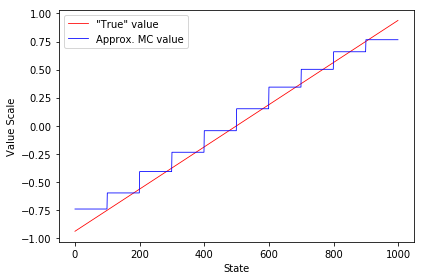

In [313]:
weights = gradient_MC(env, policy, ep=10000, alpha=0.0001, init_w=init_w, v_hat=v_hat, grad_v_hat=grad_v_hat)
V = [v_hat(st, weights) for st in range(1,1001)]   # 1..1001 because we won't plot terminal states
plot_linear(V, env)

Solve with proper function approximator

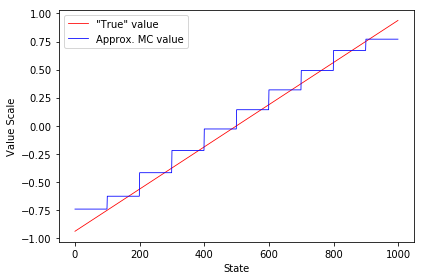

In [314]:
model = FunctionApproximator(learn_rate=0.0001, nb_groups=10, group_size=100)
gradient_MC_fix(env, policy, ep=10000, gamma=1.0, model=model)
V = [model.evaluate(st) for st in range(1,1001)]
plot_linear(V, env)

# Recreate Figure 9.1

We need to track frequency of visit to each state, let's modify our algorithm slightly. Changes are marked with arrows.

In [199]:
def gradient_MC_track_freq(env, policy, ep, gamma, model):
    count = defaultdict(float)  # <- how many times state visited
    total = 0                   # <- total state visits to all states
    
    for _ in range(ep):
        traj, T = generate_episode(env, policy)
        Gt = 0
        for t in range(T-1,-1,-1):
            St, _, _, _ = traj[t]      # (st, rew, done, act)
            _, Rt_1, _, _ = traj[t+1]
            
            count[St] += 1
            total += 1
            
            Gt = gamma * Gt + Rt_1
            model.train(St, Gt)
            
    for key, val in count.items():  # <- calc. frequency
        count[key] = val / total
        
    return count                    # <- return freq.

Solve.
* In the book alg. is run for **100k** episodes, alpha=**2e-5**. Here we run for **10k** episodes alpha=**1e-4** to save time.

In [215]:
model = FunctionApproximator(learn_rate=0.0001, nb_groups=10, group_size=100)
freq = gradient_MC_fix_track_freq(env, policy, ep=10000, gamma=1.0, model=model)

Plot

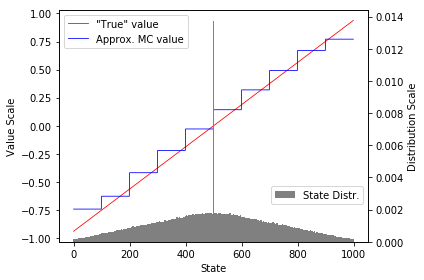

In [317]:
plot_linear(V, env, freq=freq, saveimg='assets/fig_0901.png')  # 'assets/fig_0901.png'